<a href="https://colab.research.google.com/github/samoliver3/capstone-STRIP-AI/blob/main/STRIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mayo Clinic STRIP AI: Predicting Stroke Etiology from Whole Slide Digital Pathology Images
This notebook represents exploratory analysis and modeling for predicting ischemic stroke etiology.
* Student name: Sam Oliver
* Student pace: self-paced
* Scheduled project review: 
* Instructor name: Abhineet Kulkarni

# Overview of This Project
Stroke Thromboembolism Registery of Imaging and Pathology (STRIP) is a project run by the Mayo Clinic Neurovascular Lab across multiple centers with the following goal: histopathologic characterization of thromboemboli of various etiologies and examining clot composition and its relation to mechanical thrombectomy revascularization. This project will take advantage of resources collected by STRIP to predict stroke etiology (the origin of the stroke).
## Description of the problem
In the United States, over 700,000 people suffer an ischemic stroke every year, and stroke is the second most common cause of death in the world. Around 25% of people that have a stroke suffer one or more additional strokes. Identifying stroke etiology improves the likelihood of survival. 
## The dataset
The data from this project will come from the Mayo Clinic and is also part of a Kaggle competition. This dataset comprises more than one-thousand digital pathology images representing a blood clot that has manifested from a patient that has suffered an acute ischemic stroke (AIS).
## The stakeholder
The stakeholder is the Mayo Clinic, which is offering cash rewards to the creators of the top five best-scoring entries according to a scoring algorithm. The Mayo Clinic is asking for entries to classify images into one of the two major AIS categories for each image in a test set. These two major categories include Cardioembolic (CE) strokes and Large Artery Atherosclerosis (LAA) strokes.
## The evaluation algorithm
The evaluation algorithm is a weighted multi-class logarithmic loss that produces an effect of placing equal **importance on each category** for the final score.
The formula is as follows:

![eval_formula](https://drive.google.com/uc?export=view&id=19qGOpvOoahqduMBI28ywYLnG1EiLDfyg)


Definitions of elements in the formula:
* M - number of classes
* N - number of images in the class set
* y_ij - equal to 1 if observation i belongs to class j and 0 otherwise
* p_ij - predicted probability that image i belongs to class j.
* w_i - the weight of each class. w1 = w2 = 0.5 because both classes are weighted equally.

# Exploratory Data Analysis (EDA)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
!nvidia-smi

y
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Import packages and data

In [ ]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import os
from os import listdir
from google.colab import drive
from pathlib import Path

from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from PIL import Image

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras import activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from numpy import asarray

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

from tqdm import tqdm
import datetime

import gc

from tensorflow.random import set_seed
set_seed(13)

In [ ]:
# define paths for the data
train_path = '/content/drive/MyDrive/Flatiron/Capstone/train_images'
test_path = '/content/drive/MyDrive/Flatiron/Capstone/test'

In [ ]:
# load csv files in
train_df = pd.read_csv('/content/drive/MyDrive/Flatiron/Capstone/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Flatiron/Capstone/test.csv')

train_df.head()

image_id  center_id patient_id  image_num label
0  006388_0         11     006388          0    CE
1  008e5c_0         11     008e5c          0    CE
2  00c058_0         11     00c058          0   LAA
3  01adc5_0         11     01adc5          0   LAA
4  026c97_0          4     026c97          0    CE

There are several different centers that have contributed images to this dataset. I'm not sure what the image_num column is supposed to keep track of.

In [ ]:
test_df.head()

image_id  center_id patient_id  image_num
0  006388_0         11     006388          0
1  008e5c_0         11     008e5c          0
2  00c058_0         11     00c058          0
3  01adc5_0         11     01adc5          0

The test dataset does not have a label column because of the nature of the Kaggle competition. It is concealed so that predictions are made on the test set and scored with the evaluation algorithm on the Kaggle competition.

## Preview metadata

First, look for null-data and inspect type of data

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    4 non-null      object
 1   center_id   4 non-null      int64 
 2   patient_id  4 non-null      object
 3   image_num   4 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 256.0+ bytes


No null data in either set.
Now, look into distribution of images in respect to the target in the train dataset.

In [ ]:
train_df.label.value_counts()

CE     547
LAA    207
Name: label, dtype: int64

In the train dataset, there are 547 Cardiacembolic images and 207 Large Artery Atherosclerosis images.
Let's visualize this distribution below.

Text(0.5, 1.0, 'Distribution of Stroke Etiology in the Train Dataset')

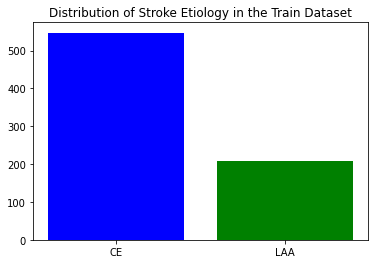

In [ ]:
# visualize distribution
plt.bar(['CE', 'LAA'], [547, 207], color=['b', 'g'])
plt.title('Distribution of Stroke Etiology in the Train Dataset')

The distribution is almost 2:1 in favor of CE.

Now, visualize the number of images of clots obtained from the same patient (image_num) column and the distribution of how many images are taken at each center. I'm adapting some visualization efforts used by Robert Kwiatkowski in this competition in his first section, "Images metadata", which can be found [here](https://www.kaggle.com/code/datark1/eda-images-processing-and-exploration). 

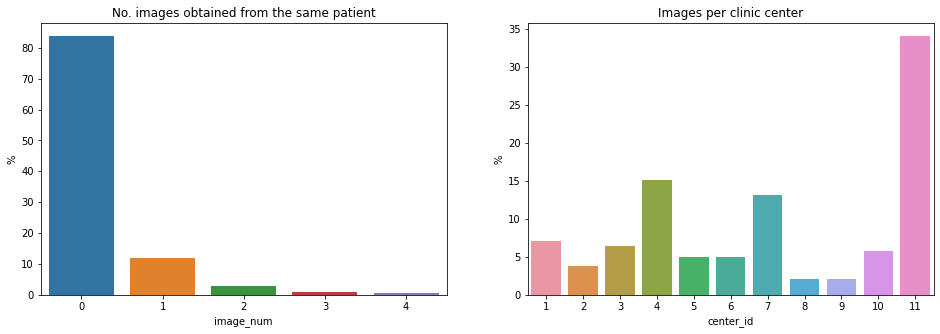

In [ ]:
# group data together for both categories and plot with Seaborn

# group data
p_no = train_df.groupby('image_num')['image_num'].count().div(len(train_df)).mul(100)
c_no = train_df.groupby("center_id")['center_id'].count().div(len(train_df)).mul(100)

# plot
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(x=p_no.index, y=p_no.values, ax=ax[0])
ax[0].set_title("No. images obtained from the same patient"), ax[0].set_ylabel("%")
sns.barplot(x=c_no.index, y=c_no.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")
plt.show()

Clinic 11 represents around 35% of the total images. Centers 8 & 9 have a low concentration of images in the dataset with only about 2% each. Around 10% of the images are clots from patients that are already represented with a picture of another clot in the dataset. 

## Preview some images

Let's take a look at some of the images in the train set.

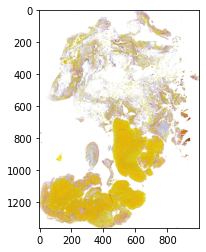

In [ ]:
images = []

# png file type in train folder
for filename in glob.glob('/content/drive/MyDrive/Flatiron/Capstone/train_images/*.png'):
    im=Image.open(filename)
    images.append(im)

plt.imshow(images[0])

Here's the first image. Let's check out the metadata of the images list for a quick sanity check, and also check out some more of the images.

In [ ]:
# check out data types for the image list and individual images
i_l_t = type(images)     # type for images list
i_t = type(images[4])     # type for an image in the image list

# look at size of the list- should be 754. I know it will be 752- I'll fix later
i_l_s = len(images)

# print out meta findings
print(f"Type of image list: {i_l_t}")
print(f"Type of image in the list: {i_t}")
print(f"Number of images in the set: {i_l_s}")

Type of image list: <class 'list'>
Type of image in the list: <class 'PIL.PngImagePlugin.PngImageFile'>
Number of images in the set: 752


Images are png type, but there are only 752 of them, even though there are 754 in the original dataset. This discrepancy is because I am using a modified dataset from the original Kaggle competition. I am using a dataset from Jirka Borovec who converted the original iamges with .tif type and reduced the size of the images through a technique to reduce empty background space. These images are .png type and they compose the folder found in my train_path. The link to the dataset is [here](https://www.kaggle.com/datasets/jirkaborovec/stroke-blood-clot-origin-1k-scale-bg-crop).

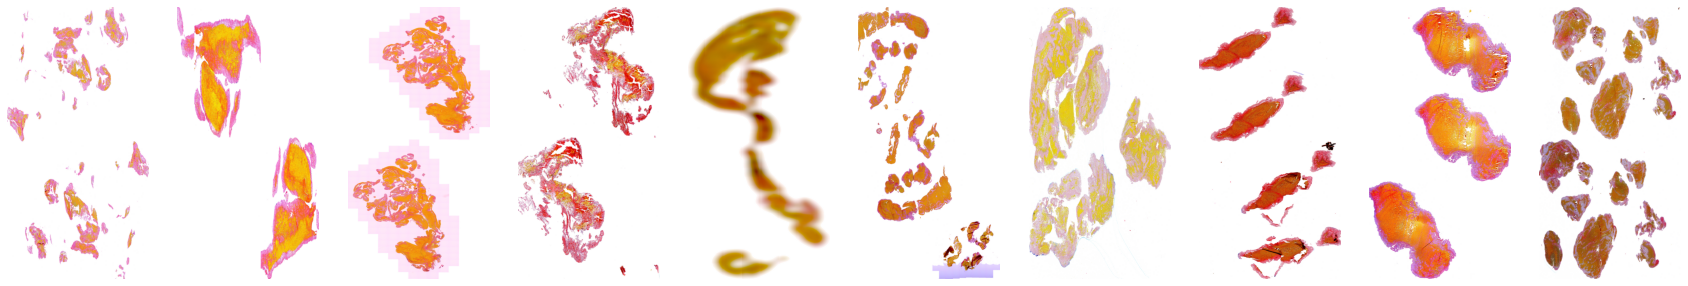

In [ ]:
# Look at some more images in the train set:

# Generate list of 10 different random numbers from 0-751
import random
r_l = random.sample(range(0, 751), 10)     # sample with replacement

fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(10):
  ax[i].imshow(images[r_l[i]])     # show image at the random index
  ax[i].axis('off')
  ax[i].set_aspect('auto')

plt.show()

It seems like a lot of these images are mirrored. But I think what's occurring here is that the cross-sectional area of each clot is scanned on both sides; or it might be the case that each individual fragment is cut, and multiple cross-sectional areas of the same clot are scanned.

## Clean the dataset
Steps to take:
1. There are several images that should be removed from the dataset because they are very smooth. The resolution of these images are very low and may reduce success of any future prediction algorithm created in this project. The IDs of these images are found from a Kaggle discussion on this project [here](https://www.kaggle.com/competitions/mayo-clinic-strip-ai/discussion/338256), and they include: 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0.
2. There are two images that are described in the train metadata but not in the train images. I am going to find the IDs of these two missing images and remove them from the train csv (metadata) because I will have to associate each image with labels from the train csv file, and the presence of additional labels may interfere with that process as well as other, further exploration of train metadata.

In [ ]:
# I want to create a list or df column of string type data that contains all the 
# names (IDs) of each individual image.
t_img_ids = os.listdir(train_path)
print(len(t_img_ids))
print(t_img_ids[5])

752
098f15_0.png


Recall the '.png' ending for each of these images. Remove these endings for ease later when I find the missing entries.

In [ ]:
# loop through images in t_img_ids and remove .png ending
train_img_ids = []     # new list to append altered objects

for i_id in t_img_ids:
  new_id = i_id[:-4]
  # train_img_ids.append(i_id.removesuffix('.png'))
  train_img_ids.append(new_id)

# preview one of the altered list items for a quick sanity check
train_img_ids[82]

'24f8f5_0'

In [ ]:
# get list of image ids in the train csv file
train_df_ids = train_df.image_id.to_list()

# get the missing elements through set subtraction
missing_imgs = list(set(train_df_ids) - set(train_img_ids))
missing_imgs

['6baf51_0', 'b894f4_0']

So, the images to clean out of the train_csv file include: b894f4_0, 6baf51_0, 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0.
The images to remove from the train image dataset include: 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0.

In [ ]:
# remove following ids from train_df:
# b894f4_0, 6baf51_0, 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0
train_df = train_df[(train_df.image_id != 'b894f4_0') & 
                     (train_df.image_id != '6baf51_0') & 
                     (train_df.image_id != '7b9aaa_0') &
                     (train_df.image_id != '5adc4c_0') & 
                     (train_df.image_id != 'bb06a5_0') & 
                     (train_df.image_id != 'e26a04_0')]

# length should be 748
len(train_df)

748

In [ ]:
# also, reset the index of train_df
train_df = train_df.reset_index(drop=True)

# check the modified dataframe
train_df.head()

image_id  center_id patient_id  image_num label
0  006388_0         11     006388          0    CE
1  008e5c_0         11     008e5c          0    CE
2  00c058_0         11     00c058          0   LAA
3  01adc5_0         11     01adc5          0   LAA
4  026c97_0          4     026c97          0    CE

Looks good. Now, move on to clean the image folder. To reiterate from above, remove images with these IDs: 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0. I will be copying the image dataset in my Google Drive, removing these images, and then calling this new file path for train_path.

In [ ]:
# redefine train_path
train_path = '/content/drive/MyDrive/Flatiron/Capstone/train_images_cleaned'

# check if the images were actually removed - length should be 748
len(os.listdir(train_path))

748

## Create dataframe with labeled images
Creating this dataframe will allow for previewing labeled images and it will also allow me to more easily split the data into train and test categories.

Make sure that the image IDs in my image folder are the same as the image IDs in the CSV file so that I can make sure I am working with the exact same data. This step will ensure accurate labels later.

In [ ]:
# first, check if the filenames for the image directory lines up with the csv 
# img ids

t_img_ids = os.listdir(train_path)

# loop through images in t_img_ids and remove .png ending
train_img_ids = []     # new list to append altered objects

for i_id in t_img_ids:
  new_id = i_id[:-4]
  # train_img_ids.append(i_id.removesuffix('.png'))
  train_img_ids.append(new_id)

# create object with train csv file image ids
csv_ids = train_df.image_id.to_list()

# sort the lists
train_img_ids.sort()
csv_ids.sort()

# check if the lists are the same
if train_img_ids == csv_ids:
  print('The lists are the same')
else:
  print ('F')

The lists are the same


In [ ]:
# create new df
df_all = train_df.copy()
df_all = df_all.drop(['center_id', 'patient_id', 'image_num'], axis=1)

print(len(df_all))
df_all.head()

748


image_id label
0  006388_0    CE
1  008e5c_0    CE
2  00c058_0   LAA
3  01adc5_0   LAA
4  026c97_0    CE

In [ ]:
# change image_id to image_path

# define strings to append to front and back of image ids
s_app = '/content/drive/MyDrive/Flatiron/Capstone/train_images_cleaned/'
s_suff = '.png'

img_id_list = df_all.image_id.to_list()
img_paths_cleaned = [s_app + img_id + s_suff for img_id in img_id_list]

df_all['image_path'] = img_paths_cleaned

# remove image_id and keep image_path
df_all = df_all.drop('image_id', axis=1)

df_all.head()

label                                         image_path
0    CE  /content/drive/MyDrive/Flatiron/Capstone/train...
1    CE  /content/drive/MyDrive/Flatiron/Capstone/train...
2   LAA  /content/drive/MyDrive/Flatiron/Capstone/train...
3   LAA  /content/drive/MyDrive/Flatiron/Capstone/train...
4    CE  /content/drive/MyDrive/Flatiron/Capstone/train...

## Preview images from each category
Is it possible to simply view differences between the two etiologies? Probably not, but it's worth taking a look.



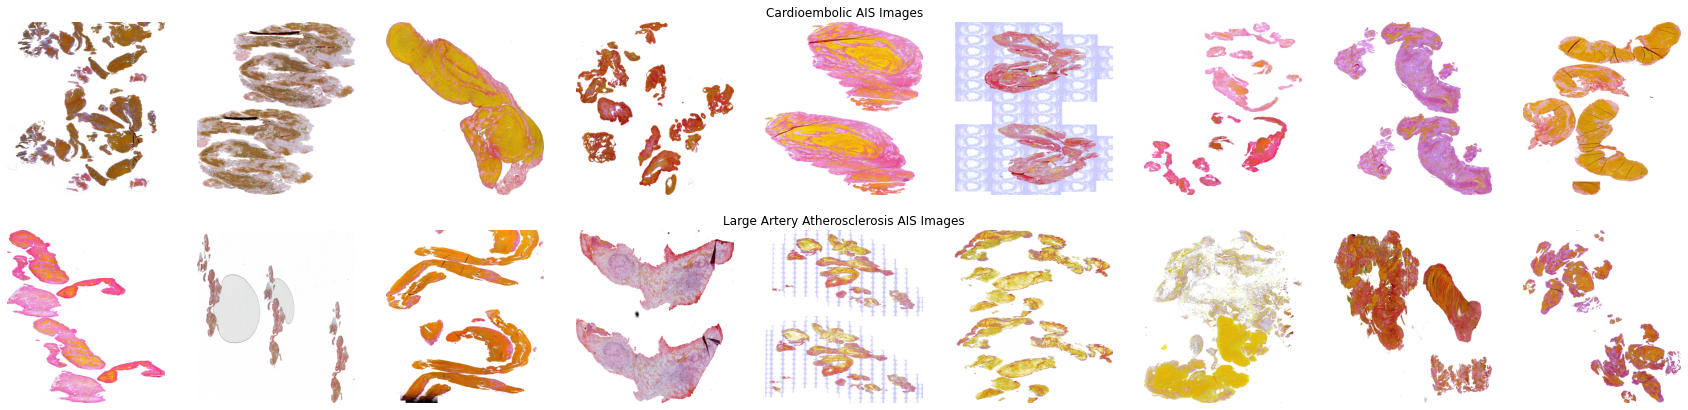

In [ ]:
# Make a list of images in CE (0) category and view them
ce_img_tmp = df_all[df_all['label']=='CE']['image_path'].iloc[:9].to_list()
laa_img_tmp = df_all[df_all['label']=='LAA']['image_path'].iloc[:9].to_list()

# append the real images to list
ce_images = []
laa_images = []

# png file type in train folder
for filename in ce_img_tmp:
    im=Image.open(filename)
    ce_images.append(im)

for filename in laa_img_tmp:
    im=Image.open(filename)
    laa_images.append(im)

# plot
fig, ax = plt.subplots(2, 9, figsize=(30, 7))
for i in range(9):
  ax[0][i].imshow(ce_images[i])
  ax[1][i].imshow(laa_images[i]) 
  ax[0][i].axis('off')
  ax[0][i].set_aspect('auto')
  ax[1][i].axis('off')
  ax[1][i].set_aspect('auto')

  if i == 4:
    ax[0][i].set_title('Cardioembolic AIS Images')
    ax[1][i].set_title('Large Artery Atherosclerosis AIS Images')

plt.show()

The variation between the different CE & LAA images is pretty large. I'm not sure I can spot any major trends. There is a weird blue background on the sixth image that is in part due to the imaging technique for some of the images and in part due to the background reduction technique utilized for the images I am using in this project. There is also presence of this effect in the fifth LAA image. I'm not sure if the sac-looking entities on the second LAA image are part of the clot or if it is a result of the process of creating the image. I'm worried about losing too much resolution of these photos in comparison to the original whole slide, .tif images. There is a substantial amount of detail lost in the transition from those images to these .png images. 

# Modeling

## Prepare images for modeling & feature engineering
Use ImageDataGenerator as a feature engineering method to alter the images. This process allows for reduction in bias that may be learned by future models. For example, some of the images in the set have some sort of background likely produced by the image-scanning process. The permutations found in ImageDataGenerator allow for a reduction in such biases.

In [ ]:
# use ImageDataGenerator
permutes = ImageDataGenerator(
    rescale = 1. / 255,     # multiply the data by the value provided
    shear_range = 0.2,     # this distorts the image along an axis
    zoom_range = 0.2,     # range for random zoom
    horizontal_flip = True     # random horizontal flip
)

I have a strong feeling that I will change these or modify these permutations in some way in this project. Or I may return to the original Kaggle dataset to select .tif iamges that are higher resolution. I'm not sure if my .png pictures are able to depict some of the fine-detailed entities like platelettes, RBCs, and WBCs foudn in the blood clots.

### Split data into train and test sets

In [ ]:
from sklearn.model_selection import train_test_split
df_tt = df_all.copy()
train, test = train_test_split(df_tt, test_size=0.2, random_state=42, 
                               shuffle=True)

NameError: ignored

Straightforward split... don't need to split into X_train, y_train, etc. because I am going to use the train and test dataset for permuting the images and reducing bias in the next step.

### Fit ImageDataGenerator to the datasets

Purpose of this step is to fit the ImageDataGenerator onto the images in the train and test set to reduce bias that may be learned by future models. I can't really tell the difference between the categories (CE & LAA), but the whole point of this project is to allow the computer to find these differences. That is why it is important to take some initiative to reduce bias, even if there really might not be much of a presence in this particular set. 

In [ ]:
# fit the image modifier/permuter
train_gen = permutes.flow_from_dataframe(dataframe=train, x_col='image_path',
                                         y_col='label', target_size=(256,256),
                                         class_mode='binary', batch_size=13,
                                         seed=42)

test_gen = permutes.flow_from_dataframe(dataframe=test, x_col='image_path',
                                         y_col='label', target_size=(256,256),
                                         class_mode='binary', batch_size=15,
                                         seed=42)

Found 598 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


The train set has 598 images and the test set has 150 images.

## Baseline model

### Setup Callbacks for efficiency

In [ ]:
# Going to use EarlyStopping Callback
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=5, 
                   min_delta=0.01)

# Instantiate ModelCheckpoint Callback
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', 
                     save_best_only=True)

### Create and fit the model

I am adapting this code from my project dealing with detecting pneumonia from x-ray imaging, which can be found [here](https://github.com/samoliver3/dsc-phase-4-project/blob/main/index.ipynb). However, the original basis of the architecture of this model is from Francois Chollet and his blog post titled ["Building powerful image classification models using very little data"](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [ ]:
# Baseline model

# trying an SGD optimizer with a low learning rate
optimizer = keras.optimizers.SGD(learning_rate=1e-6)

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)))    # re-scaled image size.
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

# end model with sigmoid activation (great for binary classification)
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',     # loss function should be binary for 2 col
    optimizer=optimizer,
    metrics=['acc']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

The model is sequential with several Conv2D and MaxPooling2D layers. I did make the image size fairly small... I think. I'll need to double check that, and maybe make some changes in the ImageDataGenerator calls to permute the images. I may want to keep these bigger and with better resolution.

In [ ]:
# keep track of time used while training this model.
original_start = datetime.datetime.now()
start = datetime.datetime.now()

# fit the model with the train generator. Use a standard approach for defining'
# the steps per epoch. (# of images for train or validation / batch size)
history = model.fit(
    x=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size,
    validation_data=test_gen,
    validation_steps=test_gen.n//test_gen.batch_size,
    epochs=20,
    callbacks=[es, mc]
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/20
46/46 [==============================] - 56s 942ms/step - loss: 0.6758 - acc: 0.7308 - val_loss: 0.6764 - val_acc: 0.7133
Epoch 2/20
46/46 [==============================] - 43s 926ms/step - loss: 0.6743 - acc: 0.7308 - val_loss: 0.6748 - val_acc: 0.7067
Epoch 3/20
46/46 [==============================] - 42s 919ms/step - loss: 0.6726 - acc: 0.7308 - val_loss: 0.6754 - val_acc: 0.7133
Epoch 4/20
46/46 [==============================] - 42s 925ms/step - loss: 0.6709 - acc: 0.7308 - val_loss: 0.6726 - val_acc: 0.7133
Epoch 5/20
46/46 [==============================] - 42s 919ms/step - loss: 0.6695 - acc: 0.7308 - val_loss: 0.6719 - val_acc: 0.7133
Epoch 6/20
46/46 [==============================] - 41s 904ms/step - loss: 0.6679 - acc: 0.7308 - val_loss: 0.6694 - val_acc: 0.7133
Epoch 7/20
46/46 [==============================] - 42s 911ms/step - loss: 0.6665 - acc: 0.7308 - val_loss: 0.6675 - val_acc: 0.7133
Epoch 8/20
46/46 [==============================] - 42s 911ms/step - 

Validation accuracy and train accuracy were absolutely stagnant the whole time. That's not the most exciting result. It probably greedily classified the images and couldn't find any other important features... Something like that.

### Evaluate model

In [ ]:
test_loss, test_acc = history.model.evaluate(test_gen)
print(f'Test Loss: {test_loss}')
print(f'Test Acc: {test_acc}')

10/10 [==============================] - 9s 873ms/step - loss: 0.6625 - acc: 0.7133
Test Loss: 0.6625144481658936
Test Acc: 0.7133333086967468


I think it's a good idea, at least in these initial phases to aim for accuracy above around 80% or so because 71.33% is the same as just guessing CE everytime in the test set. Around a 9% gain in that would give me some confidence to iterate on a model and make improvements that are largely in respect to loss (like the evaluation metric used for this Kaggle comp) or maybe even just accuracy or an F1 score. 

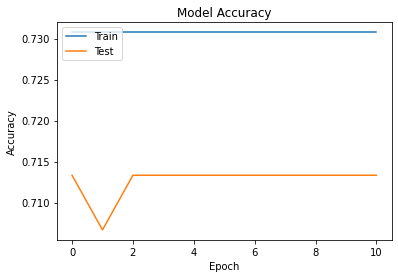

In [ ]:
# model accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Flat the whole time... roughly looks like the fraction of CE to whole quantity of images for each set. Model is probably classifying everything as CE.

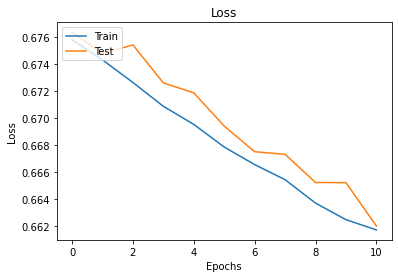

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Based on the graphs, I have a suspicion that the model is simply predicting everything as 'CE'.

In [ ]:
# Create predictions for the model
y_hat_tmp = history.model.predict(test_gen)
y_hat_tmp

array([[0.46207967],
       [0.46646023],
       [0.45577425],
       [0.4559606 ],
       [0.4560189 ],
       [0.46298864],
       [0.46591482],
       [0.45871976],
       [0.46207237],
       [0.4507819 ],
       [0.4692728 ],
       [0.4689472 ],
       [0.46788263],
       [0.46726054],
       [0.4500752 ],
       [0.4685142 ],
       [0.45971927],
       [0.46795014],
       [0.4562161 ],
       [0.47277507],
       [0.46118665],
       [0.46963236],
       [0.4519059 ],
       [0.45937902],
       [0.46159497],
       [0.4587716 ],
       [0.46714407],
       [0.45252568],
       [0.46830803],
       [0.46000496],
       [0.46521798],
       [0.45830247],
       [0.4720378 ],
       [0.46703646],
       [0.4608638 ],
       [0.46148294],
       [0.45898807],
       [0.4603387 ],
       [0.46662655],
       [0.46712926],
       [0.45797545],
       [0.47176445],
       [0.45069078],
       [0.4622665 ],
       [0.46419895],
       [0.46451142],
       [0.46098608],
       [0.468

Seems like the first model is predicting everything as Cardioembolic.

In [ ]:
print(len(test.loc[test.label=='LAA']))
len(test.loc[test.label=='CE'])

43


107

Testing to see if the first model actually did predict everything as CE.

In [ ]:
107/(43+107)*100

71.33333333333334

I'm going to carry out some evaluation of the baseline model. First, cast CE & LAA categories to numbers (0 or 1), then use that for calculations involved in confusion matrix and classification report.

In [ ]:
df_test_tmp = test.copy()
df_test_tmp.loc[df_test_tmp['label'] == 'CE', 'label'] = 0     # CE is now 0
df_test_tmp.loc[df_test_tmp['label'] == 'LAA', 'label'] = 1     # LAA is now 1

df_test_tmp.head(10)

label                                         image_path
580     0  /content/drive/MyDrive/Flatiron/Capstone/train...
356     0  /content/drive/MyDrive/Flatiron/Capstone/train...
133     1  /content/drive/MyDrive/Flatiron/Capstone/train...
250     0  /content/drive/MyDrive/Flatiron/Capstone/train...
299     1  /content/drive/MyDrive/Flatiron/Capstone/train...
388     0  /content/drive/MyDrive/Flatiron/Capstone/train...
336     1  /content/drive/MyDrive/Flatiron/Capstone/train...
155     0  /content/drive/MyDrive/Flatiron/Capstone/train...
527     0  /content/drive/MyDrive/Flatiron/Capstone/train...
734     1  /content/drive/MyDrive/Flatiron/Capstone/train...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


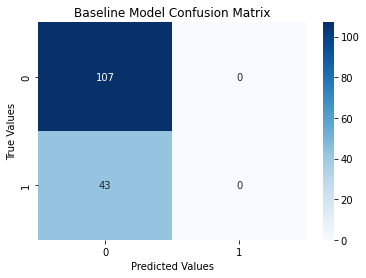

In [ ]:
# Create predictions for the model
y_hat_tmp = history.model.predict(test_gen)

# classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
thresh = 0.5
y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values

y_t = df_test_tmp.label.astype(int)

cm_vals = confusion_matrix(y_t, y_hat)     # get confusion matrix values

# plot confusion matrix values
sns.heatmap(
    cm_vals, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
)

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Baseline Model Confusion Matrix')
plt.show()

If it wasn't clear before, it should be absolutely clear what the model did in the first attempt...

In [ ]:
print(classification_report(y_t, y_hat))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      1.00      0.83       107
           1       0.00      0.00      0.00        43

    accuracy                           0.71       150
   macro avg       0.36      0.50      0.42       150
weighted avg       0.51      0.71      0.59       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Helper functions for evaluating models

List of what I want to be evaluated:
1. Test accuracy and loss
2. Graphs of loss and accuracy for test and train set - important for observation of convergence.
3. Confusion matrix for predicted values of the test set and true values.
4. I might as well print a classification report just in case I decide to use any other metrics in the future for evaluation (like F1).

In [ ]:
def eval(history, model, test_gen, test_set):
  # print loss and accuracy of the model on the test set
  test_loss, test_acc = history.model.evaluate(test_gen)
  print(f'Test Loss: {test_loss}')
  print(f'Test Acc: {test_acc}')

  # create plots for accuracy and loss
  fig, ax = plt.subplots(1, 2, figsize = (12,8))
  ax[0].plot(history.history['acc'])
  ax[0].plot(history.history['val_acc'])
  ax[0].set_title('Model Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend(['Train', 'Test'], loc='upper left')

  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend(['Train', 'Test'], loc='upper left')

  plt.show()

  # create df with integer labels instead of CE or LAA to use soon.
  df_test_tmp = test.copy()
  df_test_tmp.loc[df_test_tmp['label'] == 'CE', 'label'] = 0     # CE is now 0
  df_test_tmp.loc[df_test_tmp['label'] == 'LAA', 'label'] = 1     # LAA is now 1

  # plot confusion matrix - create predictions for the model
  y_hat_tmp = history.model.predict(test_gen)

  # classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
  thresh = 0.5
  y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values
  y_t = df_test_tmp.label.astype(int)
  cm_vals = confusion_matrix(y_t, y_hat)     # get confusion matrix values

  # plot confusion matrix values
  sns.heatmap(
      cm_vals, 
      annot=True, 
      cmap='Blues', 
      fmt='0.5g'
  )
  plt.xlabel('Predicted Values')
  plt.ylabel('True Values')
  plt.title('Baseline Model Confusion Matrix')
  plt.show()

  # display classification report
  print(classification_report(y_t, y_hat))

## VGG-19 model

From [MathWork's description](https://www.mathworks.com/help/deeplearning/ref/vgg19.html): "VGG-19 is a convolutional neural network that is 19 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database".
Additionally, [this article](https://iq.opengenus.org/vgg19-architecture/) explains the architecture of VGG-19 more fully. 

### Create and fit the model

In [ ]:
# instantiate a VGG19 parameters w/ pre-determined weights from imagenet 
vgg_params = VGG19(
     weights='imagenet',
     input_shape=(256, 256, 3),
     # Don't include ImageNet classifier at top b/c input_shape is changed
     include_top=False 
)

vgg_params.trainable = False     # freeze the base model

# create sequential model, add VGG-19 frozen base model, then add more layers
model = models.Sequential()
model.add(vgg_params)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))    # sigmoid activation for binary_x

# Adam optimizer seems to be working best.

# Compile the model
model.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=['acc']
)

model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                2097216   
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22,121,665
Trainable params: 2,097,281
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

history = model.fit(
    x=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size,
    validation_data=test_gen,
    validation_steps=test_gen.n//test_gen.batch_size,
    epochs=50,
    callbacks=[es, mc]
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/50
46/46 [==============================] - 44s 931ms/step - loss: 0.7543 - acc: 0.6472 - val_loss: 0.6293 - val_acc: 0.6800
Epoch 2/50
46/46 [==============================] - 42s 915ms/step - loss: 0.6040 - acc: 0.7191 - val_loss: 0.7670 - val_acc: 0.7133
Epoch 3/50
46/46 [==============================] - 42s 921ms/step - loss: 0.4924 - acc: 0.7592 - val_loss: 0.6607 - val_acc: 0.7267
Epoch 4/50
46/46 [==============================] - 42s 923ms/step - loss: 0.4959 - acc: 0.7742 - val_loss: 0.7593 - val_acc: 0.7200
Epoch 5/50
46/46 [==============================] - 42s 909ms/step - loss: 0.4296 - acc: 0.7910 - val_loss: 0.6407 - val_acc: 0.6933
Epoch 6/50
46/46 [==============================] - 42s 910ms/step - loss: 0.4249 - acc: 0.8127 - val_loss: 0.6947 - val_acc: 0.7133
Epoch 7/50
46/46 [==============================] - 42s 910ms/step - loss: 0.4264 - acc: 0.8127 - val_loss: 0.8240 - val_acc: 0.7067
Epoch 8/50
46/46 [==============================] - 42s 920ms/step - 

### Evaluate model

In [ ]:
# evaluate the best model epoch
from keras.models import load_model
saved_model = load_model('best_model.h5')

10/10 [==============================] - 9s 885ms/step - loss: 0.7279 - acc: 0.6800
Test Loss: 0.727939784526825
Test Acc: 0.6800000071525574


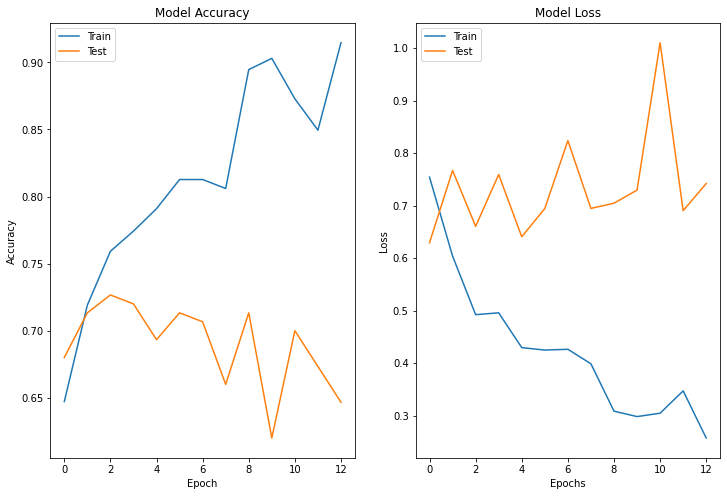

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


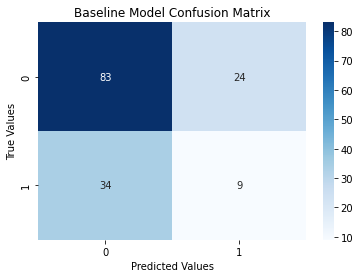

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       107
           1       0.27      0.21      0.24        43

    accuracy                           0.61       150
   macro avg       0.49      0.49      0.49       150
weighted avg       0.58      0.61      0.60       150



In [ ]:
eval(history, saved_model, test_gen, test)

This time around, VGG-19 is maybe doing a little more than just guessing, but it's still not an ideal situation. There's no convergence between the test and train set for loss or accuracy, and the metrics are not as great as I would like to see. I think I should also start testing performance against a loss formula similar to that of which will be used in the Kaggle competition. I think some tweaking, especially with how image permutations are handled, and maybe even loading in the .tif files from the original train set will help with improving performance. I will also look into some other algorithms to use for this project.

This model actually performs worse than simply random guessing or guessing one category or the other for each case.

## Prepare images for modeling & FE
Going to shoot for larger image sizes and maybe change the image modification strategy.

In [ ]:
# use ImageDataGenerator
permutes = ImageDataGenerator(
    #rescale = 1. / 255,     # normalize
    shear_range = 0.2,     # this distorts the image along an axis
    zoom_range = 0.2,     # range for random zoom
    horizontal_flip = True     # random horizontal flip
)

# fit the image modifier/permuter
train_gen = permutes.flow_from_dataframe(dataframe=train, x_col='image_path',
                                         y_col='label', target_size=(512,512),
                                         class_mode='binary', batch_size=16,
                                         seed=42)

test_gen = permutes.flow_from_dataframe(dataframe=test, x_col='image_path',
                                         y_col='label', target_size=(512,512),
                                         class_mode='binary', batch_size=16,
                                         seed=42)

Found 598 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


## VGG-19 2nd attempt

Goal for this model is to use higher resolution images.

### Create and fit the model

In [ ]:
# Setup some Callbacks for improved efficiency

# Going to use EarlyStopping Callback
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10, 
                   min_delta=0.01)

# Instantiate ModelCheckpoint Callback
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', 
                     save_best_only=True)

In [ ]:
# instantiate a VGG19 parameters w/ pre-determined weights from imagenet 
vgg_params = VGG19(
     weights='imagenet',
     input_shape=(512, 512, 3),
     # Don't include ImageNet classifier at top b/c input_shape is changed
     include_top=False 
)

vgg_params.trainable = False     # freeze the base model

# create sequential model, add VGG-19 frozen base model, then add more layers
model = models.Sequential()
model.add(vgg_params)
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# adding dropout layer
model.add(Dropout(0.25))
model.add(Dense(1))

# Compile the model
model.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=['acc']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               16777344  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,801,857
Trainable params: 16,777,473
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

history = model.fit(
    x=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size,
    validation_data=test_gen,
    validation_steps=test_gen.n//test_gen.batch_size,
    epochs=50,
    callbacks=[es, mc]
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/50
37/37 [==============================] - 70s 2s/step - loss: 4.0815 - acc: 0.7354 - val_loss: 4.3918 - val_acc: 0.7153
Epoch 2/50
37/37 [==============================] - 67s 2s/step - loss: 4.0815 - acc: 0.7354 - val_loss: 4.3918 - val_acc: 0.7153
Epoch 3/50
37/37 [==============================] - 67s 2s/step - loss: 4.1345 - acc: 0.7320 - val_loss: 4.4989 - val_acc: 0.7083
Epoch 4/50
37/37 [==============================] - 68s 2s/step - loss: 4.0815 - acc: 0.7354 - val_loss: 4.4989 - val_acc: 0.7083
Epoch 5/50
37/37 [==============================] - 68s 2s/step - loss: 4.1875 - acc: 0.7285 - val_loss: 4.4989 - val_acc: 0.7083
Epoch 6/50
37/37 [==============================] - 69s 2s/step - loss: 4.1345 - acc: 0.7320 - val_loss: 4.2847 - val_acc: 0.7222
Epoch 7/50
37/37 [==============================] - 68s 2s/step - loss: 4.1610 - acc: 0.7302 - val_loss: 4.4989 - val_acc: 0.7083
Epoch 8/50
37/37 [==============================] - 68s 2s/step - loss: 4.2140 - acc: 0.72

### Evaluate the model

10/10 [==============================] - 14s 1s/step - loss: 4.4218 - acc: 0.7133
Test Loss: 4.421818256378174
Test Acc: 0.7133333086967468


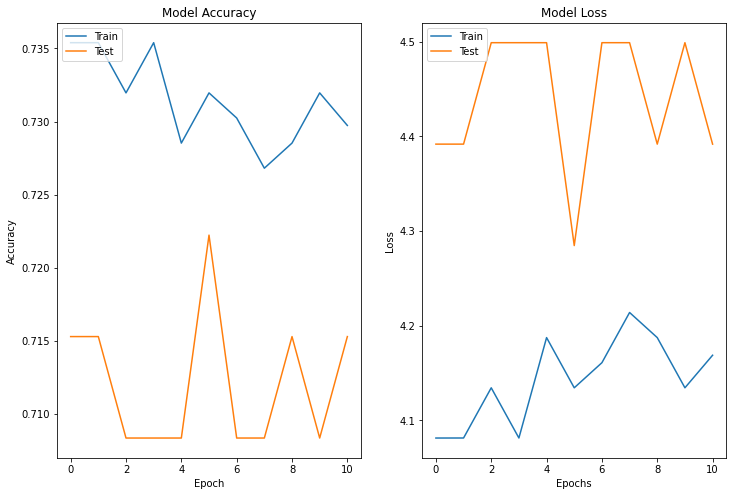

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


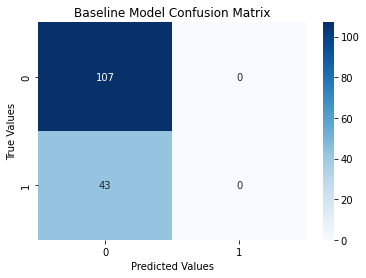

              precision    recall  f1-score   support

           0       0.71      1.00      0.83       107
           1       0.00      0.00      0.00        43

    accuracy                           0.71       150
   macro avg       0.36      0.50      0.42       150
weighted avg       0.51      0.71      0.59       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
eval(history, saved_model, test_gen, test)

I have a feeling that the models are not doing well simply because there is not enough information in the pictures do to lack of quality. I am going to try to use the whole slide images from the original dataset.

# Modeling Part 2: Importing Files from a Tiled (Filtered) Dataset

This dataset comes from Mrinal Tyagi and can be found [here](https://www.kaggle.com/datasets/tr1gg3rtrash/mayo-clinic). <br> The author of the code that produced this dataset was able to 'tile' the original wholeslide images, which essentially means that the author sliced each wholeslide image into smaller pieces using DeepZoomGenerator method from the Openslide package. <br> This strategy allows for the high resolution of the original wholeslide images to be retained, and these higher-resolution images could help modeling efforts detect signals that get lost in lower-resolution images. The author was also able to rid the dataset of tiled images that are made up of 70% or more blank space. There are many wholeslide images in this dataset that have quite a bit of blank space in the image and this occurence could decrease the reliability of predictions.

Another important note here is that this dataset is composed of about 81k tiles of CE category and about 41k LAA, so roughly a 2:1 ratio of CE to LAA images.

This dataset has smaller, more resolute images and will likely allow for easier utilization in modeling and will hopefully allow for more accurate models to be created.

Following steps from [here](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) <br> Credits to Kaustubh Gupta

## Import dataset from Kaggle

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download tr1gg3rtrash/mayo-clinic

100% 85.1G/85.1G [11:50<00:00, 184MB/s]
100% 85.1G/85.1G [11:50<00:00, 129MB/s]


In [ ]:
!unzip mayo-clinic.zip

Streaming output truncated to the last 5000 lines.
  inflating: First Experiment/train/LAA/f5ce23_0_24_82_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_24_83_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_24_84_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_24_85_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_24_86_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_24_87_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_24_88_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_24_89_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_24_90_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_24_91_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_25_81_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_25_82_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_25_83_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_25_84_17.png  
  inflating: First Experiment/train/LAA/f5ce23_0_25_8

In [ ]:
train_path = '/content/FirstExperiment/train/'

Going to use split folders package in order to separate data into various folders

In [ ]:
# I will use split-folders to split the data into train, test, and validation
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Image preprocessing + feature engineering

In [ ]:
import splitfolders
splitfolders.ratio(train_path, output="output",
    seed=1337, ratio=(.8, .15, .05), group_prefix=None, move=True) # default values

Copying files: 124837 files [00:08, 14271.28 files/s]


Splitting folders into 80% train, 15% test, and 5% validation. I likely will not use *all* the images from any category under any situation, so the distribution percentages aren't entirely important; but it is a pretty standard distribution for splitting up data.

In [ ]:
# ImageDataGenerators for train, test, validation
# generate images
permutes = ImageDataGenerator(
    #rescale = 1. / 255,     # multiply the data by the value provided
    shear_range = 0.2,     # this distorts the image along an axis
    zoom_range = 0.2,     # range for random zoom
    horizontal_flip = True     # random horizontal flip
)

# initialize variables to reduce redundancies
batch_size = 32     #  number of samples that the NN uses each iteration

train_gen = permutes.flow_from_directory(
    '/content/output/train',
    target_size = (512, 512),
    batch_size = 32,
    class_mode = 'binary'
)

test_gen = permutes.flow_from_directory(
    '/content/output/test',
    target_size = (512, 512),
    batch_size = 32,
    class_mode = 'binary'
)

val_gen = permutes.flow_from_directory(
    '/content/output/val',
    target_size = (512, 512),
    batch_size = 32,
    class_mode = 'binary'
)

Found 99869 images belonging to 2 classes.
Found 6243 images belonging to 2 classes.
Found 18725 images belonging to 2 classes.


Trying to keep the tiles with large-ish resolution. Tiles are originally 600x600, and I will use 512x512 for the baseline model.

## Baseline (tiled) model

### Create and fit the model

In [ ]:
# Baseline model
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(512, 512, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))

# end model with sigmoid activation (great for binary classification)
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',     # loss function should be binary for 2 col
    optimizer='sgd',
    metrics=['acc']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 256)     295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 984064)            0

Simple model for baseline predictions on the tiled set. Hopefully will be able to have predictions that are better than simply guessing one or the other category and hopefully there will be features that are able to be extracted by the model.

In [ ]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

history = model.fit(
    x=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size//20,
    validation_data=test_gen,
    validation_steps=test_gen.n//test_gen.batch_size//20,
    callbacks=[es, mc],
    epochs=50
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/50
156/156 [==============================] - 1083s 7s/step - loss: nan - acc: 0.6514 - val_loss: nan - val_acc: 0.6474
Epoch 2/50
156/156 [==============================] - 1101s 7s/step - loss: nan - acc: 0.6581 - val_loss: nan - val_acc: 0.6803
Epoch 3/50
156/156 [==============================] - 1117s 7s/step - loss: nan - acc: 0.6498 - val_loss: nan - val_acc: 0.6691
Epoch 4/50
156/156 [==============================] - 1114s 7s/step - loss: nan - acc: 0.6536 - val_loss: nan - val_acc: 0.6643
Epoch 5/50
156/156 [==============================] - 1129s 7s/step - loss: nan - acc: 0.6536 - val_loss: nan - val_acc: 0.6611
Epoch 6/50
156/156 [==============================] - 1131s 7s/step - loss: nan - acc: 0.6627 - val_loss: nan - val_acc: 0.6635
Epoch 7/50
156/156 [==============================] - 1124s 7s/step - loss: nan - acc: 0.6589 - val_loss: nan - val_acc: 0.6442
Epoch 7: early stopping
Training took a total of 2:10:01.850981


Each epoch took a while to conclude. It will be important to decrease size of images and decrease steps per epoch + other methods to reduce computational stress.

### Evaluate the model

In [ ]:
test_loss, test_acc = history.model.evaluate(test_gen, steps=20)
print(f'Test Loss: {test_loss}')
print(f'Test Acc: {test_acc}')

20/20 [==============================] - 55s 3s/step - loss: nan - acc: 0.6641
Test Loss: nan
Test Acc: 0.6640625


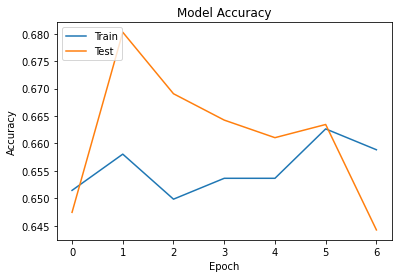

In [ ]:
# model accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show() 

Accuracy is relatively unchanged from initialization to termination of the model.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


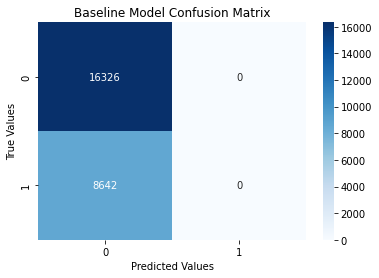

              precision    recall  f1-score   support

           0       0.65      1.00      0.79     16326
           1       0.00      0.00      0.00      8642

    accuracy                           0.65     24968
   macro avg       0.33      0.50      0.40     24968
weighted avg       0.43      0.65      0.52     24968



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#from sklearn.metrics import ConfusionMatrixDisplay

# plot confusion matrix - create predictions for the model
y_hat_tmp = history.model.predict(
    test_gen
)

# classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
thresh = 0.5
y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values
#y_t = test.target.astype(int)
cm_vals = confusion_matrix(test_gen.classes, y_hat)     # get confusion matrix values

# plot confusion matrix values
sns.heatmap(
  cm_vals, 
  annot=True, 
  cmap='Blues', 
  fmt='0.5g'
)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Baseline Model Confusion Matrix')
plt.show()

# display classification report
print(classification_report(test_gen.classes, y_hat))

The model only guessed CE category everytime. This is not useful...

## Efficientnet model

I saw on Kaggle that some users were supposedly having some small successes with EfficientNet, so I gave this model a try. EfficientNet is a CNN that uniformly scales all dimensions of an image using a compound coefficient.

In [ ]:
!pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras.applications
from tensorflow.keras.applications import EfficientNetB0

Using EfficientNetB0 to avoid overflowing memory. I tried EffNetB6, which overflowed memory very quickly. I may try to scale into EffNetV2 aor higher NetB's at some point, but I'll wait to see for how this model works.

### Image preprocessing

Preprocess images with size of 224x224 pixels because this size is what EffNetB0 expects

In [ ]:
# ImageDataGenerators for train, test, validation
# generate images
permutes = ImageDataGenerator(
    rescale = 1. / 255,     # multiply the data by the value provided
    shear_range = 0.2,     # this distorts the image along an axis
    zoom_range = 0.2,     # range for random zoom
    horizontal_flip = True,     # random horizontal flip
    rotation_range = 40    # degree range for random rotations
)

train_gen = permutes.flow_from_directory(
    '/content/output/train',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)

test_gen = permutes.flow_from_directory(
    '/content/output/val',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)

val_gen = permutes.flow_from_directory(
    '/content/output/test',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 99869 images belonging to 2 classes.
Found 18725 images belonging to 2 classes.
Found 6243 images belonging to 2 classes.


### Setup callbacks

In [ ]:
# Going to use EarlyStopping Callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Instantiate ModelCheckpoint Callback
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', 
                     save_best_only=True)

### Create and fit the model

In [ ]:
efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='max',
    classes=2
)

model = models.Sequential()
model.add(efficient_net)
model.add(Dense(units=112, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=224, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

Utilizing some regularization strategy Dropout in order to reduce overfitting. Activation for last layer in the model should be sigmoid because I will be using binary crossentropy for loss function- this loss function is best for this project due to equal weighting of desirability for valid predictions across both categories and because of the representation of two classes as opposed to a different value.

In [ ]:
import tensorflow as tf

model.compile(
    loss = 'binary_crossentropy',    
    metrics = ['acc'],
    optimizer = tf.keras.optimizers.Adam(1e-6)
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_9 (Dense)             (None, 112)               143472    
                                                                 
 dropout_6 (Dropout)         (None, 112)               0         
                                                                 
 dense_10 (Dense)            (None, 224)               25312     
                                                                 
 dropout_7 (Dropout)         (None, 224)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 225       
                                                                 
Total params: 4,218,580
Trainable params: 4,176,557
No

In [ ]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

history = model.fit(
    x=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size//25,
    validation_data=test_gen,
    validation_steps=test_gen.n//test_gen.batch_size//25,
    callbacks=[es, mc],
    epochs=100
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
124/124 [==============================] - 301s 2s/step - loss: 2.0997 - acc: 0.3775 - val_loss: 2.2175 - val_acc: 0.3560
Epoch 2/100
124/124 [==============================] - 285s 2s/step - loss: 1.5905 - acc: 0.4232 - val_loss: 1.1125 - val_acc: 0.3220
Epoch 3/100
124/124 [==============================] - 285s 2s/step - loss: 1.2895 - acc: 0.4753 - val_loss: 0.9795 - val_acc: 0.4266
Epoch 4/100
124/124 [==============================] - 278s 2s/step - loss: 1.2118 - acc: 0.4942 - val_loss: 1.1961 - val_acc: 0.3736
Epoch 5/100
124/124 [==============================] - 279s 2s/step - loss: 1.0819 - acc: 0.5343 - val_loss: 0.7553 - val_acc: 0.5598
Epoch 6/100
124/124 [==============================] - 281s 2s/step - loss: 1.0706 - acc: 0.5378 - val_loss: 0.7421 - val_acc: 0.6005
Epoch 7/100
124/124 [==============================] - 278s 2s/step - loss: 1.0630 - acc: 0.5378 - val_loss: 0.7984 - val_acc: 0.6033
Epoch 8/100
124/124 [==============================] - 279s 2s

### Model Evaluation

In [ ]:
test_loss, test_acc = history.model.evaluate(val_gen)
print(f'Test Loss: {test_loss}')
print(f'Test Acc: {test_acc}')

196/196 [==============================] - 246s 1s/step - loss: 0.6800 - acc: 0.6309
Test Loss: 0.6799530982971191
Test Acc: 0.6309466361999512


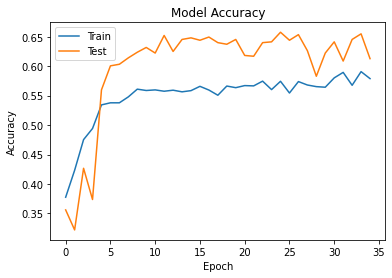

In [ ]:
# model accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Accuracy largely unchanced after 8th or so epoch.

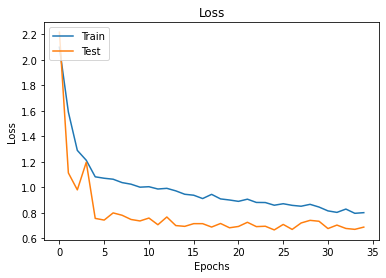

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Loss flattens for test set after 10-15 epochs.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


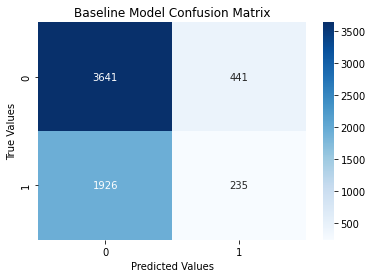

              precision    recall  f1-score   support

           0       0.65      0.89      0.75      4082
           1       0.35      0.11      0.17      2161

    accuracy                           0.62      6243
   macro avg       0.50      0.50      0.46      6243
weighted avg       0.55      0.62      0.55      6243



In [ ]:
# plot confusion matrix - create predictions for the model
y_hat_tmp = history.model.predict(
    val_gen
)

# classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
thresh = 0.5
y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values
#y_t = test.target.astype(int)
cm_vals = confusion_matrix(val_gen.classes, y_hat)     # get confusion matrix values

# plot confusion matrix values
sns.heatmap(
  cm_vals, 
  annot=True, 
  cmap='Blues', 
  fmt='0.5g'
)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Baseline Model Confusion Matrix')
plt.show()

# display classification report
print(classification_report(val_gen.classes, y_hat))

The model isn't simply guessing CE label this time, but it isn't much of an improvement. But I think these results are the most promising thus far...

### Evaluate on the png dataset
Also, I can practice Kaggle competition submission here.

Can I use these results on the original .tif files to make predictions on the wholeslide images?

I could probably read these images in and tile them like the images in the EffNet model and then combine the losses for each tile and divide them by total number of tiles for each image to get final loss total for each image.

I could just try to validate on some of the png files.

In [ ]:
png_test = pd.read_csv('/content/test.csv')
png_test.head()

image_id  center_id patient_id  image_num
0  006388_0         11     006388          0
1  008e5c_0         11     008e5c          0
2  00c058_0         11     00c058          0
3  01adc5_0         11     01adc5          0

In [ ]:
# going to create train dataframe with the wholeslide image paths
png_test["file_path"] = png_test["image_id"].apply(
    lambda x: "/content/drive/MyDrive/Flatiron/Capstone/train_images_cleaned/" + x + ".png")

png_test

image_id  center_id patient_id  image_num  \
0  006388_0         11     006388          0   
1  008e5c_0         11     008e5c          0   
2  00c058_0         11     00c058          0   
3  01adc5_0         11     01adc5          0   

                                           file_path  
0  /content/drive/MyDrive/Flatiron/Capstone/train...  
1  /content/drive/MyDrive/Flatiron/Capstone/train...  
2  /content/drive/MyDrive/Flatiron/Capstone/train...  
3  /content/drive/MyDrive/Flatiron/Capstone/train...

In [ ]:
# use ImageDataGenerator
permutes = ImageDataGenerator(
    rescale = 1. / 255,     # multiply the data by the value provided
    shear_range = 0.2,     # this distorts the image along an axis
    zoom_range = 0.2,     # range for random zoom
    horizontal_flip = True     # random horizontal flip
)

png_test_gen = permutes.flow_from_directory(
    "/content/drive/MyDrive/Flatiron/Capstone/png_test_images",
    target_size=(224,224),
    class_mode='binary', 
    shuffle=False,
    batch_size=1
)

Found 4 images belonging to 2 classes.


In [ ]:
y_hat = history.model.predict(
    png_test_gen,
    steps=4,      # each step represents one image
    verbose=1
)
y_hat

4/4 [==============================] - 1s 410ms/step


array([[0.],
       [0.],
       [0.],
       [1.]], dtype=float32)

In [ ]:
preds_df = pd.DataFrame(y_hat, columns=['predictions'])
preds_df

predictions
0          0.0
1          0.0
2          0.0
3          1.0

I'm not sure why it's giving me whole number predictions, but 3/4 predictions are correct. I'll need % probabilities for submission.

## MIL Model

Multiple Instance Learning seems like a good idea for this model because it will bag the tiles, which allows for grouping of categories. I think effectively it will allow for retention of high resolution images for training and allow for signal detection in images that do contain the signal instead of created predictions for each image even if there is no signal in a particular tile.

Following a [tutorial from Keras](https://keras.io/examples/vision/attention_mil_classification/#configuration-parameters) for how to create an attention-based deep multiple learning model.

### Configure parameters

In [ ]:
POSITIVE_CLASS = 1     # LAA is positive class
BAG_COUNT = 1000
VAL_BAG_COUNT = 300
BAG_SIZE = 3     # number images per bag
PLOT_SIZE = 3
ENSEMBLE_AVG_COUNT = 1

### Prepare bags

In [ ]:
def create_bags(input_data, input_labels, positive_class, bag_count, instance_count):

    # Set up bags.
    bags = []
    bag_labels = []

    # Count positive samples.
    count = 0

    for _ in range(bag_count):

        # Pick a fixed size random subset of samples.
        index = np.random.choice(input_data.shape[0], instance_count, replace=False)
        instances_data = input_data[index]
        instances_labels = input_labels[index]

        # By default, all bags are labeled as 0.
        bag_label = 0

        # Check if there is at least a positive class in the bag.
        if positive_class in np.array(instances_labels):

            # Positive bag will be labeled as 1.
            bag_label = 1
            count += 1

        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))

    print(f"Positive bags: {count}")
    print(f"Negative bags: {bag_count - count}")

    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels))

Create dataframe with the tiled dataset and provide labels. Then, split into training and val data

In [ ]:
# create dataframe with labels
train_path_CE = '/content/output/train/CE/'     
train_CE_df = pd.DataFrame()

train_CE_df['files'] = os.listdir(train_path_CE)     # define column of files

# append whole file path to the dataframe
train_CE_df['file_path']  = train_CE_df['files'].apply(
    lambda x: train_path_CE + x
)

train_CE_df = train_CE_df.drop('files', axis=1)    # drop the now irrelevant col
train_CE_df['label'] = 0     # specify label. CE is 0
train_CE_df.head()

file_path  label
0  /content/output/train/CE/623f89_0_12_37_16.png      0
1   /content/output/train/CE/547474_0_9_73_16.png      0
2    /content/output/train/CE/f2c002_0_5_1_16.png      0
3    /content/output/train/CE/e732f6_1_4_8_16.png      0
4    /content/output/train/CE/c63918_0_0_5_15.png      0

In [ ]:
# create dataframe with labels
train_path_LAA = '/content/output/train/LAA/'     
train_LAA_df = pd.DataFrame()

train_LAA_df['files'] = os.listdir(train_path_LAA)     # define column of files

# append whole file path to the dataframe
train_LAA_df['file_path'] = train_LAA_df['files'].apply(
    lambda x: train_path_LAA + x
)

train_LAA_df = train_LAA_df.drop('files', axis=1)    # drop the now irrelevant col
train_LAA_df['label'] = 1     # specify label. LAA is 1

# concatenate train_LAA df with train_CE df to make train dataset
train_df = pd.concat([train_CE_df, train_LAA_df])

# shuffle the dataframe
train_df = train_df.sample(frac=1, ignore_index=True, random_state=42)
train_df

file_path  label
0        /content/output/train/CE/251c77_0_18_2_15.png      0
1       /content/output/train/CE/0e4dac_0_36_36_17.png      0
2       /content/output/train/LAA/e10fdb_0_14_7_17.png      1
3      /content/output/train/LAA/c9d53d_0_27_20_16.png      1
4        /content/output/train/CE/14d2fa_0_13_8_16.png      0
...                                                ...    ...
99864     /content/output/train/CE/d20177_0_4_2_17.png      0
99865   /content/output/train/CE/36a149_0_48_18_16.png      0
99866   /content/output/train/LAA/3982bf_0_5_74_17.png      1
99867     /content/output/train/CE/eebf8d_0_2_5_16.png      0
99868    /content/output/train/CE/64d167_0_1_16_15.png      0

[99869 rows x 2 columns]

Now that I have the train dataset created, make the validation dataset using the same process.

In [ ]:
# create dataframe with labels
val_path_CE = '/content/output/val/CE/'     
val_CE_df = pd.DataFrame()

val_CE_df['files'] = os.listdir(val_path_CE)     # define column of files

# append whole file path to the dataframe
val_CE_df['file_path'] = val_CE_df['files'].apply(
    lambda x: val_path_CE + x
)

val_CE_df = val_CE_df.drop('files', axis=1)    # drop the now irrelevant col
val_CE_df['label'] = 0     # specify label. CE is 0
val_CE_df.head()

# create dataframe with labels
val_path_LAA = '/content/output/val/LAA/'     
val_LAA_df = pd.DataFrame()

val_LAA_df['files'] = os.listdir(val_path_LAA)     # define column of files

# append whole file path to the dataframe
val_LAA_df['file_path'] = val_LAA_df['files'].apply(
    lambda x: val_path_LAA + x
)

val_LAA_df = val_LAA_df.drop('files', axis=1)    # drop the now irrelevant col
val_LAA_df['label'] = 1     # specify label. LAA is 1

# concatenate val_LAA df with val_CE df to make val dataset
val_df = pd.concat([val_CE_df, val_LAA_df])

# shuffle the dataframe
val_df = val_df.sample(frac=1, ignore_index=True, random_state=42)
val_df

file_path  label
0       /content/output/val/CE/b07b42_0_28_30_17.png      0
1      /content/output/val/LAA/845d82_0_13_37_17.png      1
2        /content/output/val/CE/d36b5f_0_5_10_16.png      0
3       /content/output/val/CE/029c68_0_33_12_16.png      0
4      /content/output/val/CE/992abf_0_14_122_17.png      0
...                                              ...    ...
18720    /content/output/val/CE/a4c877_3_8_15_16.png      0
18721     /content/output/val/CE/33da32_0_3_5_16.png      0
18722  /content/output/val/CE/3020ef_0_18_117_17.png      0
18723    /content/output/val/CE/8be762_0_9_15_16.png      0
18724   /content/output/val/LAA/5fde88_0_5_10_16.png      1

[18725 rows x 2 columns]

In [ ]:
len(val_df)

18725

In [ ]:
# to avoid OOM, I will downsize the dataframes by randomly dropping out some rows

# remove 50% of rows, randomly, for val_df & train_df
# n_r_val = len(val_df) // 2
# n_r_train = len(train_df) // 2

drop_val = np.random.choice(val_df.index, 15000, replace=False)
drop_train = np.random.choice(train_df.index, 65000, replace=False)

df_sub_val = val_df.drop(drop_val).reset_index(drop=True)
df_sub_train = train_df.drop(drop_train).reset_index(drop=True)

# check to make sure it worked
df_sub_train.head()

file_path  label
0    /content/output/train/CE/14d2fa_0_13_8_16.png      0
1  /content/output/train/LAA/a95219_0_15_10_16.png      1
2    /content/output/train/CE/251c77_0_3_24_15.png      0
3   /content/output/train/CE/e9c181_1_18_13_16.png      0
4  /content/output/train/LAA/f05449_0_19_39_17.png      1

In [ ]:
print(len(df_sub_train.label), len(df_sub_val.label))

34869 3725


train vs test size is about 85% - 15%

In [ ]:
# clear up some RAM space with del method to avoid OOM issues
del(train_df)
del(val_df)
del(val_CE_df)
del(val_LAA_df)
del(drop_train)
del(drop_val)

In [ ]:
# convert images to arrays before creating bags
val_data_arr = []
for i in range(len(df_sub_val.file_path)):
  img = Image.open(df_sub_val.file_path[i])
  img = img.resize((224, 224))
  img = img.convert('L')
  numpydata = asarray(img)
  numpydata = np.divide(numpydata, 255)    # normalize the data
  val_data_arr.append(numpydata)

df_sub_val['img_arr'] = val_data_arr

In [ ]:
# Clear some memory up
del(val_data_arr)

In [ ]:
tmp_l = []
for i in range(len(df_sub_val.img_arr)):
  tmp_l.append(df_sub_val.img_arr[i])

# convert to array
tmp_l_arr = np.array(tmp_l)

tmp_l_arr.shape

(3725, 224, 224)

In [ ]:
# convert images to arrays before creating bags
train_data_arr = []
for i in range(len(df_sub_train.file_path)):
  img = Image.open(df_sub_train.file_path[i])
  img = img.resize((224, 224))
  img = img.convert('L')
  numpydata = asarray(img)
  numpydata = np.divide(numpydata, 255)    # normalize the data
  train_data_arr.append(numpydata)

df_sub_train['img_arr'] = train_data_arr

df_sub_train.head()

file_path  label  \
0    /content/output/train/CE/14d2fa_0_13_8_16.png      0   
1  /content/output/train/LAA/a95219_0_15_10_16.png      1   
2    /content/output/train/CE/251c77_0_3_24_15.png      0   
3   /content/output/train/CE/e9c181_1_18_13_16.png      0   
4  /content/output/train/LAA/f05449_0_19_39_17.png      1   

                                             img_arr  
0  [[0.32941176470588235, 0.7764705882352941, 0.7...  
1  [[0.1803921568627451, 0.17647058823529413, 0.1...  
2  [[0.8862745098039215, 0.8862745098039215, 0.88...  
3  [[0.6235294117647059, 0.6313725490196078, 0.64...  
4  [[0.9529411764705882, 0.9529411764705882, 0.95...

In [ ]:
# clear up some RAM space with del method to avoid OOM issues

# now that I have sub_train and sub_val, I can go ahead and delete val and train
del(train_data_arr)

In [ ]:
del(train_CE_df)
del(train_LAA_df)

In [ ]:
# place each object in img_arr into an np.array
tmp_l = []
for i in range(len(df_sub_train.img_arr)):
  tmp_l.append(df_sub_train.img_arr[i])

# convert to array
tmp_l_arr_t = np.array(tmp_l)

tmp_l_arr_t.shape

(34869, 224, 224)

Now make x_train, y_train, x_val, y_val variables and then create bags for the training and validation datasets.

In [ ]:
x_train = tmp_l_arr_t
y_train = df_sub_train.label

x_val = tmp_l_arr
y_val = df_sub_val.label

# create bags for train set
train_data, train_labels = create_bags(
    x_train, y_train, POSITIVE_CLASS, BAG_COUNT, BAG_SIZE
)

# create bags for val set
val_data, val_labels = create_bags(
    x_val, y_val, POSITIVE_CLASS, VAL_BAG_COUNT, BAG_SIZE
)

Positive bags: 731
Negative bags: 269
Positive bags: 216
Negative bags: 84


In [ ]:
# clean up some more variables (remove them) to avoid OOM errors.
del(df_sub_train)
del(df_sub_val)
del(x_train)
del(y_val)
del(x_val)
del(y_train)
del(tmp_l_arr)
del(tmp_l_arr_t)
del(tmp_l)
del(numpydata)
del(img)

### Transform tiled images to arrays for modeling

In [ ]:
val_data[0][0]

'/content/output/val/LAA/b1e363_1_12_37_17.png'

Preview an image

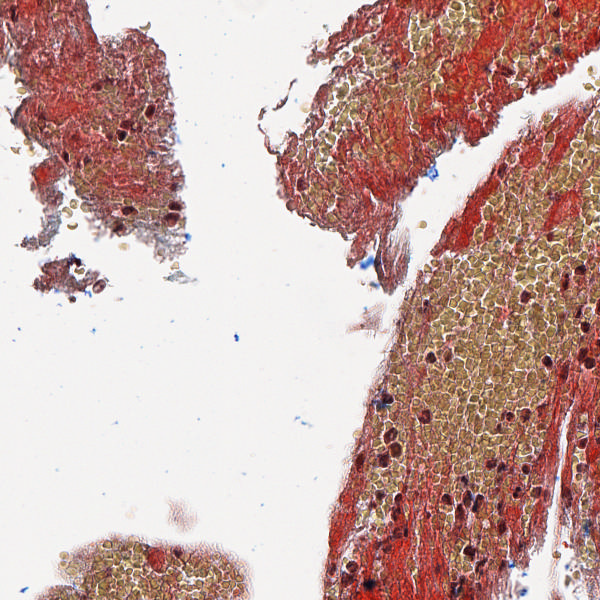

In [ ]:
img = Image.open(val_data[0][0])
img

### Attention operator implementation

In [ ]:
class MILAttentionLayer(layers.Layer):
    """Implementation of the attention-based Deep MIL layer.

    Args:
      weight_params_dim: Positive Integer. Dimension of the weight matrix.
      kernel_initializer: Initializer for the `kernel` matrix.
      kernel_regularizer: Regularizer function applied to the `kernel` matrix.
      use_gated: Boolean, whether or not to use the gated mechanism.

    Returns:
      List of 2D tensors with BAG_SIZE length.
      The tensors are the attention scores after softmax with shape `(batch_size, 1)`.
    """

    def __init__(
        self,
        weight_params_dim,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        use_gated=False,
        **kwargs,
    ):

        super().__init__(**kwargs)

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

        self.v_init = self.kernel_initializer
        self.w_init = self.kernel_initializer
        self.u_init = self.kernel_initializer

        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer

    def build(self, input_shape):

        # Input shape.
        # List of 2D tensors with shape: (batch_size, input_dim).
        input_dim = input_shape[0][1]

        self.v_weight_params = self.add_weight(
            shape=(input_dim, self.weight_params_dim),
            initializer=self.v_init,
            name="v",
            regularizer=self.v_regularizer,
            trainable=True,
        )

        self.w_weight_params = self.add_weight(
            shape=(self.weight_params_dim, 1),
            initializer=self.w_init,
            name="w",
            regularizer=self.w_regularizer,
            trainable=True,
        )

        if self.use_gated:
            self.u_weight_params = self.add_weight(
                shape=(input_dim, self.weight_params_dim),
                initializer=self.u_init,
                name="u",
                regularizer=self.u_regularizer,
                trainable=True,
            )
        else:
            self.u_weight_params = None

        self.input_built = True

    def call(self, inputs):

        # Assigning variables from the number of inputs.
        instances = [self.compute_attention_scores(instance) for instance in inputs]

        # Apply softmax over instances such that the output summation is equal to 1.
        alpha = tf.math.softmax(instances, axis=0)

        return [alpha[i] for i in range(alpha.shape[0])]

    def compute_attention_scores(self, instance):

        # Reserve in-case "gated mechanism" used.
        original_instance = instance

        # tanh(v*h_k^T)
        instance = tf.math.tanh(tf.tensordot(instance, self.v_weight_params, axes=1))

        # for learning non-linear relations efficiently.
        if self.use_gated:

            instance = instance * tf.math.sigmoid(
                tf.tensordot(original_instance, self.u_weight_params, axes=1)
            )

        # w^T*(tanh(v*h_k^T)) / w^T*(tanh(v*h_k^T)*sigmoid(u*h_k^T))
        return tf.tensordot(instance, self.w_weight_params, axes=1)

### Visualizer tool

The bag class label is positive
Bag number: 0


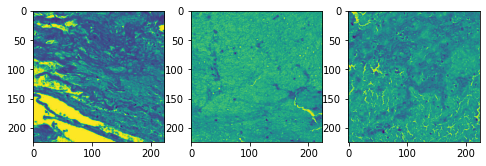

Bag number: 1


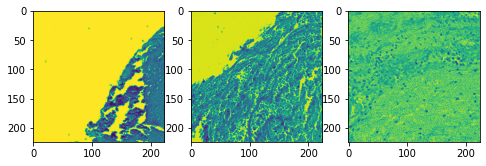

Bag number: 2


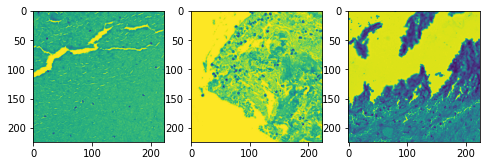

The bag class label is negative
Bag number: 4


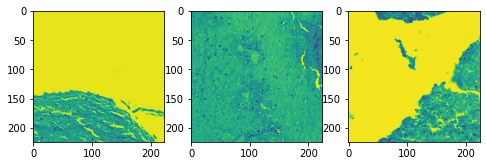

Bag number: 12


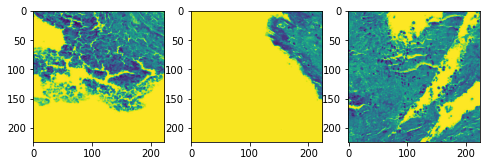

Bag number: 19


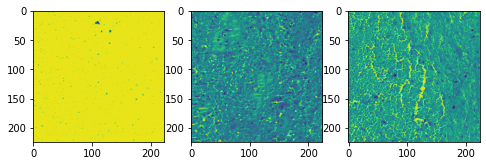

In [ ]:
def plot(data, labels, bag_class, predictions=None, attention_weights=None):

    """"Utility for plotting bags and attention weights.

    Args:
      data: Input data that contains the bags of instances.
      labels: The associated bag labels of the input data.
      bag_class: String name of the desired bag class.
        The options are: "positive" or "negative".
      predictions: Class labels model predictions.
      If you don't specify anything, ground truth labels will be used.
      attention_weights: Attention weights for each instance within the input data.
      If you don't specify anything, the values won't be displayed.
    """

    labels = np.array(labels).reshape(-1)

    if bag_class == "positive":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

        else:
            labels = np.where(labels == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    elif bag_class == "negative":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
        else:
            labels = np.where(labels == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    else:
        print(f"There is no class {bag_class}")
        return

    print(f"The bag class label is {bag_class}")
    for i in range(PLOT_SIZE):
        figure = plt.figure(figsize=(8, 8))
        print(f"Bag number: {labels[i]}")
        for j in range(BAG_SIZE):
            image = bags[j][i]
            figure.add_subplot(1, BAG_SIZE, j + 1)
            plt.grid(False)
            if attention_weights is not None:
                plt.title(np.around(attention_weights[labels[i]][j], 2))
            plt.imshow(image)
        plt.show()


# Plot some of validation data bags per class.
plot(val_data, val_labels, "positive")
plot(val_data, val_labels, "negative")

### Create model

In [ ]:
def create_model(instance_shape):

    # Extract features from inputs.
    inputs, embeddings = [], []
    shared_dense_layer_1 = layers.Dense(128, activation="relu")
    shared_dense_layer_2 = layers.Dense(64, activation="relu")
    for _ in range(BAG_SIZE):
        inp = layers.Input(instance_shape)
        flatten = layers.Flatten()(inp)
        dense_1 = shared_dense_layer_1(flatten)
        dense_2 = shared_dense_layer_2(dense_1)
        inputs.append(inp)
        embeddings.append(dense_2)

    # Invoke the attention layer.
    alpha = MILAttentionLayer(
        weight_params_dim=256,
        kernel_regularizer=keras.regularizers.l2(0.01),
        use_gated=True,
        name="alpha",
    )(embeddings)

    # Multiply attention weights with the input layers.
    multiply_layers = [
        layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))
    ]

    # Concatenate layers.
    concat = layers.concatenate(multiply_layers, axis=1)

    # Classification output node.
    output = layers.Dense(1, activation="sigmoid")(concat)

    return keras.Model(inputs, output)

### Class weights

In [ ]:
def compute_class_weights(labels):

    # Count number of postive and negative bags.
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count

    # Build class weight dictionary.
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2),
    }

### Build and train the model

In [ ]:
def train(train_data, train_labels, val_data, val_labels, model):

    # Train model.
    # Prepare callbacks.
    # Path where to save best weights.

    # Take the file name from the wrapper.
    file_path = "/tmp/best_model_weights.h5"

    # Initialize model checkpoint callback.
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        file_path,
        monitor="val_loss",
        verbose=0,
        mode="min",
        save_best_only=True,
        save_weights_only=True,
    )

    # Initialize early stopping callback.
    # The model performance is monitored across the validation data and stops training
    # when the generalization error cease to decrease.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, mode="min"
    )

    # Compile model.
    model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"],
    )

    # Fit model.
    model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=20,
        class_weight=compute_class_weights(train_labels),
        batch_size=1,
        callbacks=[early_stopping, model_checkpoint],
        verbose=0,
    )

    # Load best weights.
    model.load_weights(file_path)

    return model


# Building model(s).
instance_shape = train_data[0][0].shape
models = [create_model(instance_shape) for _ in range(ENSEMBLE_AVG_COUNT)]

# Show single model architecture.
print(models[0].summary())

# Training model(s).
trained_models = [
    train(train_data, train_labels,
          val_data, val_labels, model)
    for model in tqdm(models)
]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224)]   0           []                               
                                                                                                  
 flatten (Flatten)              (None, 50176)        0           ['input_1[0][0]']                
                                                                                              

100%|██████████| 1/1 [08:54<00:00, 534.24s/it]


### Evaluate the model

In [ ]:
def predict(data, labels, trained_models):

    # Collect info per model.
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []

    for model in trained_models:

        # Predict output classes on data.
        predictions = model.predict(data)
        models_predictions.append(predictions)

        # Create intermediate model to get MIL attention layer weights.
        intermediate_model = keras.Model(model.input, model.get_layer("alpha").output)

        # Predict MIL attention layer weights.
        intermediate_predictions = intermediate_model.predict(data)

        attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
        models_attention_weights.append(attention_weights)

        loss, accuracy = model.evaluate(data, labels, verbose=0)
        models_losses.append(loss)
        models_accuracies.append(accuracy)

    print(
        f"The average loss and accuracy are {np.sum(models_losses, axis=0) / ENSEMBLE_AVG_COUNT:.2f}"
        f" and {100 * np.sum(models_accuracies, axis=0) / ENSEMBLE_AVG_COUNT:.2f} % resp."
    )

    return (
        np.sum(models_predictions, axis=0) / ENSEMBLE_AVG_COUNT,
        np.sum(models_attention_weights, axis=0) / ENSEMBLE_AVG_COUNT,
    )

In [ ]:
# Evaluate and predict classes and attention scores on validation data.
class_predictions, attention_params = predict(val_data, val_labels, trained_models)

The average loss and accuracy are 0.69 and 72.00 % resp.


The bag class label is negative
Bag number: 0


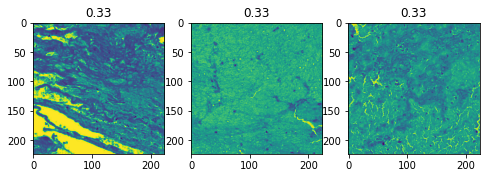

Bag number: 1


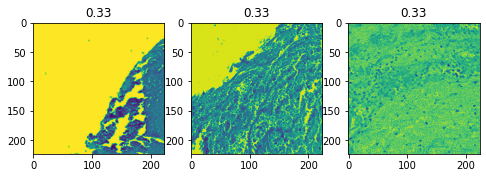

Bag number: 2


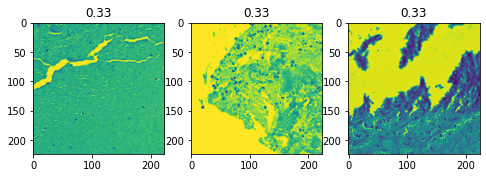

In [ ]:
# Plot some results from our validation data.
plot(
    val_data,
    val_labels,
    "negative",
    predictions=class_predictions,
    attention_weights=attention_params,
)

An error occurs if I try to plot the positive (LAA) bags. I think this error occurs because there the model does not ever predict any bag of images to be LAA. Let's go ahead and check!

In [ ]:
# check class_predictions object and see if there are any positive (LAA) preds
pos_labels = np.where(class_predictions.argmax(1) == 1)[0]
pos_labels.shape

(0,)

In [ ]:
# I can also check out some of the class_predictions to see the actual
# prediction values
print(class_predictions[:10])

[[0.50150305]
 [0.50150305]
 [0.50150305]
 [0.50150305]
 [0.50150305]
 [0.50150305]
 [0.50150305]
 [0.50150305]
 [0.50150305]
 [0.50150305]]


Looks about right. The model is almost certainly assigning the exact same or approximately the same probability that each image belongs to one of the categories... Seemingly CE as explained by the above images. It looks like it's assigning a value *just* above 50%, which results in each image being grouped into CE.

So there are no LAA predictions created by the model... That's result is obviously problematic becuase the model is not very informative, but this result is consistent with other predictions made in this project.

### Evaluation 2: test set PNG images

I'm going to try to evaluate some PNG images and see if the predictions are any different than the tiled validaiton set. 

I'll import some png images that were referenced earlier in this project. These images were created using the original wholeslide digital pathology images.

In [ ]:
png_val = pd.read_csv('/content/train.csv')
png_val.head()

image_id  center_id patient_id  image_num label
0  006388_0         11     006388          0    CE
1  008e5c_0         11     008e5c          0    CE
2  00c058_0         11     00c058          0   LAA
3  01adc5_0         11     01adc5          0   LAA
4  026c97_0          4     026c97          0    CE

I'm going to select a sample of these images to use for model evaluation

In [ ]:
# going to create dataframe with the png image paths
png_val["file_path"] = png_val["image_id"].apply(
    lambda x: "/content/drive/MyDrive/Flatiron/Capstone/train_images_cleaned/" + x + ".png")

# also delete blurry/distorted images (referenced earlier in this project in the 
# 'clean the dataset' section)

# remove following ids from png_val:
# b894f4_0, 6baf51_0, 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0
png_val = png_val[(png_val.image_id != 'b894f4_0') & 
                     (png_val.image_id != '6baf51_0') & 
                     (png_val.image_id != '7b9aaa_0') &
                     (png_val.image_id != '5adc4c_0') & 
                     (png_val.image_id != 'bb06a5_0') & 
                     (png_val.image_id != 'e26a04_0')]

# length should be 748
len(png_val)

748

Select a sample of 99 images. Deciding on this number to hopefully avoid OOM issues (small-ish sample) and because it is divisible by 3, which allows me to preserve use of previous variables dealing with bag size.

In [ ]:
# select a sample of 99 images randomly from png_val
png_val = png_val.sample(n=99).reset_index(drop=True)
png_val

image_id  center_id patient_id  image_num label  \
0   fe0cca_0          1     fe0cca          0    CE   
1   6baf51_1         11     6baf51          1   LAA   
2   eebf8d_1          1     eebf8d          1    CE   
3   d53809_0          5     d53809          0    CE   
4   3d10be_2          4     3d10be          2    CE   
..       ...        ...        ...        ...   ...   
94  baa4c4_0          4     baa4c4          0    CE   
95  f8712b_0         11     f8712b          0    CE   
96  e8dceb_0         11     e8dceb          0    CE   
97  a9573c_0          8     a9573c          0    CE   
98  31adaa_1          4     31adaa          1    CE   

                                            file_path  
0   /content/drive/MyDrive/Flatiron/Capstone/train...  
1   /content/drive/MyDrive/Flatiron/Capstone/train...  
2   /content/drive/MyDrive/Flatiron/Capstone/train...  
3   /content/drive/MyDrive/Flatiron/Capstone/train...  
4   /content/drive/MyDrive/Flatiron/Capstone/train...  
..                                                ...  
94  /content/drive/MyDrive/Flatiron/Capstone/train...  
95  /content/drive/MyDrive/Flatiron/Capstone/train...  
96  /content/drive/MyDrive/Flatiron/Capstone/train...  
97  /content/drive/MyDrive/Flatiron/Capstone/train...  
98  /content/drive/MyDrive/Flatiron/Capstone/train...  

[99 rows x 6 columns]

Also, make the label column numerical: 0 for CE and 1 for LAA

In [ ]:
# change 'label' column to contain 0 or 1. CE will be 0 & LAA will be 1
png_val.loc[png_val['label'] == 'CE', 'label'] = 0     # CE is now 0
png_val.loc[png_val['label'] == 'LAA', 'label'] = 1     # LAA is now 1

png_val.head()

image_id  center_id patient_id  image_num label  \
0  fe0cca_0          1     fe0cca          0     0   
1  6baf51_1         11     6baf51          1     1   
2  eebf8d_1          1     eebf8d          1     0   
3  d53809_0          5     d53809          0     0   
4  3d10be_2          4     3d10be          2     0   

                                           file_path  
0  /content/drive/MyDrive/Flatiron/Capstone/train...  
1  /content/drive/MyDrive/Flatiron/Capstone/train...  
2  /content/drive/MyDrive/Flatiron/Capstone/train...  
3  /content/drive/MyDrive/Flatiron/Capstone/train...  
4  /content/drive/MyDrive/Flatiron/Capstone/train...

Looks good. Now I need to prepare the data for bagging using the same methodology I used before.

First, clear up some variables in memory to avoid OOM errors.

In [ ]:
# I won't need train data for MIL model since the model has been created.
del(train_data, train_labels)

# I don't think gc.collect() is necessary while working in Colab, but I will try
# it in case.
gc.collect()

Now, convert images to arrays and preprocess the images

In [ ]:
# convert images to arrays before creating bags
png_val_arr = []
for i in range(len(png_val.file_path)):
  img = Image.open(png_val.file_path[i])
  img = img.resize((224, 224))
  img = img.convert('L')
  numpydata = asarray(img)
  numpydata = np.divide(numpydata, 255)    # normalize the data
  png_val_arr.append(numpydata)

png_val['img_arr'] = png_val_arr

png_val.head()

image_id  center_id patient_id  image_num label  \
0  fe0cca_0          1     fe0cca          0     0   
1  6baf51_1         11     6baf51          1     1   
2  eebf8d_1          1     eebf8d          1     0   
3  d53809_0          5     d53809          0     0   
4  3d10be_2          4     3d10be          2     0   

                                           file_path  \
0  /content/drive/MyDrive/Flatiron/Capstone/train...   
1  /content/drive/MyDrive/Flatiron/Capstone/train...   
2  /content/drive/MyDrive/Flatiron/Capstone/train...   
3  /content/drive/MyDrive/Flatiron/Capstone/train...   
4  /content/drive/MyDrive/Flatiron/Capstone/train...   

                                             img_arr  
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  
2  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  
3  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  
4  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...

Clear some memory to avoid OOM

In [ ]:
del(png_val_arr)

Follow previous steps for preparing data into expected structures.

In [ ]:
# place each object in img_arr into an np.array
tmp_l = []
for i in range(len(png_val.img_arr)):
  tmp_l.append(png_val.img_arr[i])

# convert to array
tmp_l_arr_t = np.array(tmp_l)

tmp_l_arr_t.shape

(99, 224, 224)

tmp_l_arr_t represents the image array data that will be used for validation bagging. Now, I will create data structure for the labels. This structure should be an array nested with arrays, each with one element containing the label for each particular image.

In [ ]:
png_val_labels = []
for l in range(len(png_val.label)):
  label_array = np.array([png_val.label[l]])
  png_val_labels.append(label_array)

png_val_labels = np.array(png_val_labels)

# check that the data structure is correct
print(type(png_val_labels[0]), png_val_labels.shape)

<class 'numpy.ndarray'> (99, 1)


In [ ]:
# also check some of the labels
png_val_labels[:5]

array([[0],
       [1],
       [0],
       [0],
       [0]])

Looks good. I also just want to preview one of these images for another assurance check.

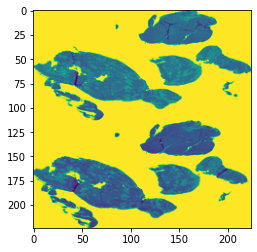

In [ ]:
plt.imshow(png_val.img_arr[3])

In [ ]:
# create bags for val set
val_data, val_labels = create_bags(
    tmp_l_arr_t, png_val_labels, POSITIVE_CLASS, VAL_BAG_COUNT, BAG_SIZE
)

Positive bags: 191
Negative bags: 109


Preview some images in the bags

The bag class label is positive
Bag number: 0


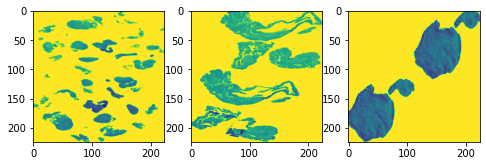

Bag number: 1


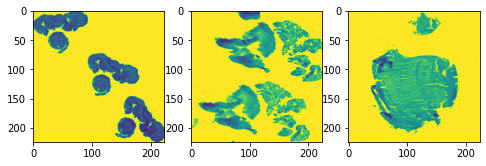

Bag number: 2


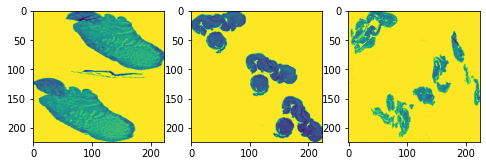

The bag class label is negative
Bag number: 3


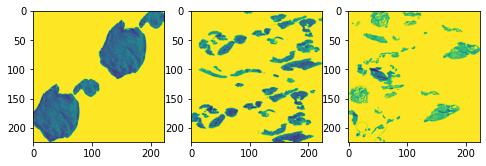

Bag number: 4


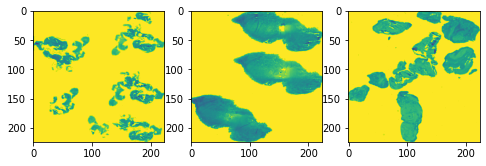

Bag number: 5


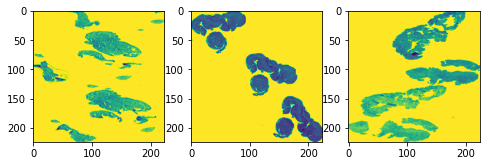

In [ ]:
# Plot some of validation data bags per class.
plot(val_data, val_labels, "positive")
plot(val_data, val_labels, "negative")

Now evaluate these images with the predict function from above.

In [ ]:
# Evaluate and predict classes and attention scores on validation data.
class_predictions, attention_params = predict(val_data, val_labels, trained_models)

The average loss and accuracy are 0.69 and 63.67 % resp.


I'm guessing there's not much difference from this evaluation and the evaluation of the previous validation set.

Plot some of the results

The bag class label is negative
Bag number: 0


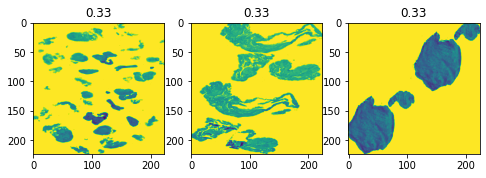

Bag number: 1


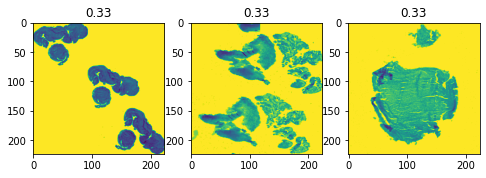

Bag number: 2


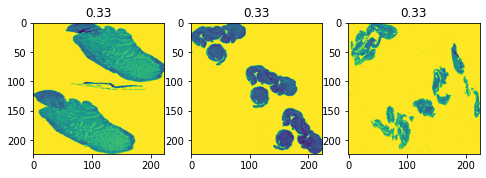

In [ ]:
plot(
    val_data,
    val_labels,
    "negative",
    predictions=class_predictions,
    attention_weights=attention_params,
)

Plotting the positive class label results in an error as before, so I suspect the same occurrence appears here in which the model predicts all images in the validation set are CE class, and all images in a single bag represent equal likelihood (0.33) that it belongs to the CE class. I'll check the labels in the positive (LAA) class to see if there is anything there.

In [ ]:
labels = np.where(class_predictions.argmax(1) == 1)[0]
labels

array([], dtype=int64)

As expected, there aren't any bags that were predicted as belonging to the LAA class.

I don't really think it makes sense to evaluate the MIL model on these non-tiled images because the goal is that the model will detect features from the tiled images in the trained bags that differentiate between the two categories and then find those details in new data to distinguish between the categories, and these features are virtually microscopic in these validation images because the tiled images essentially represent a 224x224 scaled-down version of a 600x600 pixel version of the WSI, (typically about 10kx10k images) which is about .4% of the total size of this image. Finding coherent features from the tiles and then hoping to find them in a 224x224 image of the original WSI just seems... unreasonable.

To add onto this conclusive analysis, the Keras documentation that this model is based on also tiles the validation dataset as well as the train dataset.

# Modeling Conclusions and Next Steps

## Reflections from MIL

Firstly, the results from MIL modeling were disappointing, but it wasn't entirely unexpected. I think this kind of modeling *theoretically* represents the most promising methodology for this particular project for multiple reasons, but before going over those reasons it is important to address why my results might have failed and what I could potentially improve on.
1. Image preprocessing. Images ideally will not leave out any of the channels originally represented. In my approach, my images were converted to arrays and converted to a single channel ('L' for luminance). This channel, luminance, is interpreted as the intensity of light at each point (pixel) in the image. This conversion was mainly carried out to ensure that memory did not overload, and some of the code in the MIL model is optimized for one channel instead of multiple. In future iterations of this approach, it would be interesting to incorporate more channels, especially because some of these channels can indicate presence of red blood cells, white blood cells, platelets, collagen, fibrin, and other components in blood and blood clots. The compositions of such elements could potentially indicate differences between these two categories, but the research seems mixed on whether or not there are indeed visual feature differences between CE and LAA clots.
2. More image preprocessing. It would be helpful to incorporate more images and to avoid decreasing resolution (downsizing the image) in order to maximize the chances of feature detection. These ideal situations simply could not occur for this project due to resource constraints.
3. Optimization of the attention operator. The MIL model in this project signifies my first attempt at such a model, and there are certainly ways in which I could improve on this model, especially in ways involving the attention operator. For example, there is a 'use_gated' mechanism that can be enabled for this keras application, which allows for more efficient learning of non-linear relations. This mechanism could have been useful, but it's difficult considering the (mathematical) relations in this project aren't well understood anyways.

Theoretically, I think MIL represents the most hopeful solution to stroke etiology predictions because it can preserve the quality of the images and allow for bagging of images based on one label that extends to many images. It simply is not feasible to process images that are tens of thousands of pixels by tens of thousands of pixels, and in the case of this dataset, take up .75-1.5 GB of space in most cases.